In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import geopandas as gpd
import json
import warnings
import time
from os import listdir
from os.path import isfile,join
import datetime
from branca.element import MacroElement
from matplotlib.colors import rgb2hex
from jinja2 import Template
import folium
from branca.colormap import LinearColormap
import matplotlib
import matplotlib.ticker as ticker
import requests
from sklearn.metrics import r2_score
import catboost
import re

In [2]:
def get_covid_data(info='cases'):
    if info == 'cases':
        url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
               'csse_covid_19_time_series/time_series_covid19_confirmed_US.csv').format(sep=2*'\n')
        ren_col = 'Total_cases'
        val_col = 'Daily_cases'
    if info =='deaths':
            url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                    'csse_covid_19_time_series/time_series_covid19_deaths_US.csv').format(sep=2*'\n')
            ren_col = 'Total_deaths'
            val_col = 'Daily_deaths'
    df = pd.read_csv(url)
    df = df[df['iso3']=='USA']
    df = df.dropna(subset = ['FIPS'])
    df = df[df.FIPS <= 56045]

    df.FIPS = df.FIPS.astype(int).astype(str).str.zfill(5)
    df = df[(df.Admin2 != 'Unassigned' ) & (df.Admin2.notna() )]
    df = df.drop(columns= ['UID','iso2', 'iso3', 'code3','Country_Region','Combined_Key' ])
    date_cols = [col for col in df.columns if '/20' in col]
    id_cols = [col for col in df.columns if col not in date_cols]
    df_gr = df.melt(id_vars=id_cols,value_vars=date_cols)
    df_gr[val_col] = df_gr.groupby(['FIPS'])[['value']].diff().fillna(0)
    df_gr = df_gr.rename(columns = {'value':ren_col, 'variable':'date', 
                                    'Long_':'Lng', 'Admin2':'COUNTY', 
                                   'Province_State': 'STATE', 'FIPS':'fips'})
    df_gr.date = pd.to_datetime( df_gr.date, infer_datetime_format=True)
    df_gr = df_gr.drop(columns = ['STATE', 'COUNTY'])
    return df_gr
    

In [3]:
def weekend(x):
    if x == 'Saturday' or x == 'Sunday':
        return 'Weekend'
    else:
        return 'Weekday'
    

def get_mobility_data(rolling_mean=False):
    mob_index_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'
    
    df_mobility_index = pd.read_csv(mob_index_url, parse_dates=['date'])
    df_mobility_index = df_mobility_index.dropna(subset=['fips','admin2'])
    df_mobility_index.fips = df_mobility_index.fips.astype(int)
    df_mobility_index.fips = df_mobility_index.fips.astype(str).str.zfill(5)
    df_mobility_index = df_mobility_index.rename(columns={'admin1':'STATE','admin2':'COUNTY' })
    df_mobility_index = df_mobility_index.drop(columns = ['country_code', 'admin_level'])
    df_mobility_index['weekday'] = df_mobility_index.date.dt.day_name()
    df_mobility_index = df_mobility_index[df_mobility_index.m50<200]
    df_mobility_index['weekend'] = df_mobility_index['weekday'].apply(lambda x: weekend(x))

    if rolling_mean:
        mob_col= ['m50']
        m50 = df_mobility_index.groupby(['fips','date'])[mob_col].mean()
        m50['rolling_mean_mob'] = m50[mob_col].rolling(7,min_periods=1).mean()
        m50 = m50.reset_index()
        return m50
    
    return df_mobility_index

In [4]:
df_mobility = get_mobility_data()
df_mobility_rm = get_mobility_data(rolling_mean=True)
df_mobility.sample(5)

,date,STATE,COUNTY,fips,samples,m50,m50_index,weekday,weekend
290447,2020-06-14,Oregon,Columbia County,41009,1181,2.604,33,Sunday,Weekend
298210,2020-06-25,Pennsylvania,Franklin County,42055,3298,7.877,102,Thursday,Weekday
247449,2020-06-19,New York,Wayne County,36117,3422,8.428,74,Friday,Weekday
333975,2020-05-06,Texas,Chambers County,48071,2281,13.587,77,Wednesday,Weekday
294494,2020-04-16,Pennsylvania,Allegheny County,42003,18481,0.056,1,Thursday,Weekday


In [5]:
# Importing County Level spending data from https://github.com/Opportunitylab/EconomicTracker

def get_spend_data():
    county_spending_url =  'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Affinity%20-%20County%20-%20Daily.csv'

    df_county_spending = pd.read_csv(county_spending_url,low_memory=False)

    df_county_spending['date'] = df_county_spending['year'].astype(str) + '-' + \
                                df_county_spending['month'].astype(str) + '-' + \
                                df_county_spending['day'].astype(str)
    df_county_spending.date = pd.to_datetime(df_county_spending.date, infer_datetime_format=True)
    df_county_spending.countyfips = df_county_spending.countyfips.astype(int)
    df_county_spending.countyfips = df_county_spending.countyfips.astype(str).str.zfill(5)
    df_county_spending = df_county_spending.rename(columns={'countyfips':'fips'})
    print(df_county_spending.fips.nunique())
    df_county_spending.spend_all = df_county_spending.spend_all.str.replace('.','0.')
    df_county_spending.spend_all =df_county_spending.spend_all.astype(float)
    return df_county_spending

In [6]:
df_county_spending = get_spend_data()
df_county_spending

1767


,year,month,day,fips,spend_all,date
0,2020,1,6,01001,0.0000,2020-01-06
1,2020,1,6,01003,0.0000,2020-01-06
2,2020,1,6,01009,0.0000,2020-01-06
3,2020,1,6,01015,0.0000,2020-01-06
4,2020,1,6,01019,0.0000,2020-01-06
...,...,...,...,...,...,...
346327,2020,7,19,56035,0.0294,2020-07-19
346328,2020,7,19,56037,-0.0610,2020-07-19
346329,2020,7,19,56039,-0.3370,2020-07-19
346330,2020,7,19,56041,-0.0439,2020-07-19


In [7]:
def get_covid_rates():
    case_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Cases%20-%20County%20-%20Daily.csv?raw=true'
    death_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Deaths%20-%20County%20-%20Daily.csv?raw=true'
    df_covid_case_rate = pd.read_csv(case_url,low_memory=False)
    df_covid_death_rate = pd.read_csv(death_url,low_memory=False)
    df_covid_rate = pd.DataFrame()
    for df in [df_covid_case_rate,df_covid_death_rate]:
        df['date'] = df['year'].astype(str) + '-' + \
                            df['month'].astype(str) + '-' + \
                            df['day'].astype(str)
        df.date = pd.to_datetime(df.date, infer_datetime_format=True)
        df.countyfips = df.countyfips.astype(int)
        df.countyfips = df.countyfips.astype(str).str.zfill(5)
        df = df.rename(columns={'countyfips':'fips'})
        df = df.drop(columns=['month','day','year'])
        cols = list(df.columns[1:3])
        if 'death_rate' in cols:
            
            df = df.drop(columns=['fips','date'])
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(0)
        df_covid_rate = pd.concat([df_covid_rate,df], axis =1)
    return df_covid_rate
    

In [21]:
df_covid_cases = get_covid_data(info='cases')
df_covid_deaths = get_covid_data(info='deaths')[['fips','date','Total_deaths','Daily_deaths']]
df_covid_merged = pd.merge(left = df_covid_cases, right = df_covid_deaths, on = ['fips', 'date'])
df_covid_rate = get_covid_rates()
df_covid = pd.merge(left = df_covid_merged, right = df_covid_rate, on = ['fips', 'date'], how='outer')
df_covid = df_covid.dropna(subset=['Lat'])
df_covid

,fips,Lat,Lng,date,Total_cases,Daily_cases,Total_deaths,Daily_deaths,case_rate,new_case_rate,death_rate,new_death_rate
0,01001,32.539527,-86.644082,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01003,30.727750,-87.722071,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01005,31.868263,-85.387129,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01007,32.996421,-87.125115,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01009,33.982109,-86.567906,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
609543,56037,41.659439,-108.882788,2020-08-02,247.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN
609544,56039,43.935225,-110.589080,2020-08-02,354.0,6.0,0.0,0.0,NaN,NaN,NaN,NaN
609545,56041,41.287818,-110.547578,2020-08-02,262.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN
609546,56043,43.904516,-107.680187,2020-08-02,49.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [9]:
df_county = pd.read_csv('./Data/nhgis0010_ds239_20185_2018_county.csv', encoding='latin')
df_county['fips'] = df_county.STATEA.astype(str).str.zfill(2)+df_county.COUNTYA.astype(str).str.zfill(3)
df_gini_income = pd.read_csv('./Data/nhgis0010_ds240_20185_2018_county.csv', encoding='latin')
df_gini_income = df_gini_income[['STATE', 'COUNTY', 'AKGVE001']]
df_county_demo = pd.merge(left = df_county , right = df_gini_income, on =['STATE', 'COUNTY'])
cols_A = df_county_demo.columns[df_county_demo.columns.str.endswith('A')]
margin_cols = [col for col in df_county_demo.columns if 'M' in col[4:5]]

df_county_demo = df_county_demo.drop(columns = ['GISJOIN']+list(cols_A) + margin_cols )
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,AJWBE001,AJWBE002,AJWBE003,AJWBE004,AJWBE005,AJWBE006,...,AJ35E060,AJ35E061,AJ35E062,AJ35E063,AJ35E064,AJ35E065,AJ35E066,NAME_M,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,1310,1387,455,0,32,2458,0,"Autauga County, Alabama",01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,7046,8078,1462,4,760,9752,162,"Baldwin County, Alabama",01003,0.4609


In [10]:
f = open('./Data/nhgis0010_ds239_20185_2018_county_codebook.txt','r') 
searchlines = f.readlines()
f.close()
for i in range(len(searchlines)):
    if '    Margins of error' in searchlines[i] :
        error_margin = i
col_dict={}
for col in df_county_demo.columns[4:]:
    for i, line in enumerate(searchlines):
        #print(i)
        if col[:-4] in line and 'Table' in searchlines[i-3] and i <error_margin :
            text = re.sub(r"\s+", " ", searchlines[i-3].strip())
            top_col = text.split(':')[1].strip()
        if col in line:
            text = line.strip().split(':')[1:]
            col_name = ''.join(map(str, text))
            col_name = re.sub(r"\s+", " ", col_name).strip()
            #print(col_name)
            col_dict[col] = top_col+ '_' + col_name
        
df_county_demo = df_county_demo.rename(columns=col_dict)
insurance_cols = [col for col in df_county_demo.columns if 'Insurance' in col]
hispanic_cols = [col for col in df_county_demo.columns if 'Hispanic' in col]

df_county_demo = df_county_demo.drop(columns=insurance_cols+hispanic_cols)
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,475.0,725.0,339.0,393.0,194.0,336.0,1509.0,718.0,01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,2390.0,2221.0,2183.0,1775.0,1516.0,1336.0,3961.0,2961.0,01003,0.4609


In [11]:
county_election = pd.read_csv('./Data/countypres_2000-2016.csv', sep = '\t')
county_election = county_election[county_election.year ==2016]
maj_party = county_election['party'][county_election.groupby('FIPS')['candidatevotes'].idxmax()]
fips = county_election['FIPS'][county_election.groupby('FIPS')['candidatevotes'].idxmax()]
fips_party = pd.concat([fips,maj_party], ignore_index=False,axis=1,).reset_index(drop=True).dropna()
fips_idx_county = county_election.set_index('FIPS')
pct_rep = (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes'])/ \
            (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes']+fips_idx_county[fips_idx_county['party']=='democrat']['candidatevotes'])
pct_rep = pct_rep.reset_index().rename(columns={'candidatevotes': 'pct_republican'})
fips_party = fips_party.join(pct_rep.set_index('FIPS'), on = 'FIPS')
fips_party.FIPS = fips_party.FIPS.astype(int).astype(str).str.zfill(5)
fips_party

,FIPS,party,pct_republican
0,01001,republican,0.753775
1,01003,republican,0.797922
2,01005,republican,0.528232
3,01007,republican,0.782397
4,01009,republican,0.913812
...,...,...,...
3150,56037,republican,0.789990
3151,56039,democrat,0.348999
3152,56041,republican,0.836596
3153,56043,republican,0.845484


In [12]:
total_cols = [col for col in df_county_demo.columns if 'Total' in col]
for col in total_cols:
    remaining_cols = [c for c in list(df_county_demo.columns) if c!=col]
    for df_col in remaining_cols:
        if col.split('_')[0] in df_col:
            df_county_demo[df_col] = df_county_demo[df_col]/df_county_demo[col]
df_county_demo = df_county_demo.join(fips_party.set_index('FIPS'), on = 'fips')  
df_county_demo = df_county_demo.fillna(df_county_demo.mean())
df_county_demo.isna().sum()

YEAR                                                                                   0
STATE                                                                                  0
COUNTY                                                                                 0
NAME_E                                                                                 0
Sex by Age_Total                                                                       0
                                                                                    ... 
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed      0
fips                                                                                   0
AKGVE001                                                                               0
party                                                                                106
pct_republican                                                                         0
Length: 150, dtype: i

In [14]:
def get_model_df(df_mob,df_demographics):
    df_model = pd.merge(left = df_mob, right = df_demographics, on = ['fips'])

    return df_model

In [15]:
county_dict = df_county_demo.set_index('fips')['COUNTY'].to_dict()
state_dict = df_county_demo.set_index('fips')['STATE'].to_dict()
def get_name(name_dict, x):
    
    if x in name_dict.keys():
        return name_dict[x]
    else:
        return None
df_mobility_rm['STATE'] = df_mobility_rm['fips'].apply(lambda x: get_name(state_dict, x))
df_mobility_rm['COUNTY'] = df_mobility_rm['fips'].apply(lambda x: get_name(county_dict, x))

# Mobility Reduction

In [19]:
# Creating a dataframe to record reduction in spending and mobility before and after covid
target_cols = ['rolling_mean_mob'] #,'spend_all']
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
window = covid_date -datetime.timedelta(days=10)
df_mob_covid = df_mobility_rm[df_mobility_rm.date>=window]
df_mob_pre = df_mobility_rm[(df_mobility_rm.date<window)]
df_pre_mean = df_mob_pre.groupby(['fips','date'])[target_cols].mean()

pre_covid_mean = df_pre_mean.groupby(level=[0])[target_cols].mean()
df_covid_mean = df_mob_covid.groupby(['fips','date'])[target_cols].mean()

post_covid_min_date = df_covid_mean.groupby(level=[0])[target_cols].idxmin()
for col in target_cols:
    rename_col = 'min_date_' + col
    post_covid_min_date['min_date_'+col] = post_covid_min_date[col].str[1]
    post_covid_min_date = post_covid_min_date.drop(columns=[col])
post_covid_min = df_covid_mean.groupby(level=[0])[target_cols].min()
for col in target_cols:
    post_covid_min = post_covid_min.rename(columns={col:'Min_'+col})
df_mob_spend_red = pd.concat([pre_covid_mean,post_covid_min,post_covid_min_date],axis=1)

df_mob_spend_red = df_mob_spend_red.reset_index()
df_mob_spend_red = df_mob_spend_red.rename(columns={'index':'fips'})
for col in target_cols:
    min_date_col = 'min_date_' + col
    
    df_mob_spend_red['Drop_days_'+col] = (df_mob_spend_red[min_date_col] - covid_date).dt.days
    if col!='spend_all':
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((df_mob_spend_red[col] -df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])/df_mob_spend_red[col]
        df_mob_spend_red['Pct_Red_'+col] =( df_mob_spend_red[col] - df_mob_spend_red['Min_'+col])/df_mob_spend_red[col]
    else:
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((-1*df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])
        df_mob_spend_red['Pct_Red_'+col] = -1*df_mob_spend_red['Min_'+col]
df_mob_spend_red = df_mob_spend_red[df_mob_spend_red['Pct_Red_rolling_mean_mob']>=-0.5]
df_mob_spend_red.sample(5)

,fips,rolling_mean_mob,Min_rolling_mean_mob,min_date_rolling_mean_mob,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob
2623,55099,3.975286,0.031000,2020-03-31,16,0.062013,0.992202
650,18075,9.054821,0.878429,2020-03-31,16,0.056437,0.902988
1074,25001,2.968393,0.152286,2020-04-04,20,0.047435,0.948698
585,17141,12.205321,3.127000,2020-04-12,28,0.026564,0.743800
487,15009,4.449929,0.692000,2020-05-11,57,0.014816,0.844492


In [22]:
# def get_mean_covid_rate(df):
#     x  = df_covid[df_covid.date>df_mobility_rm.date.min()]
#     x = x[x.fips =='25017']
#     x.set_index('date')['new_case_rate'].median()
mean_covid_rate_cases,mean_covid_rate_death = [],[]
for fips in df_mob_spend_red.fips.unique():
    n_days = df_mob_spend_red[df_mob_spend_red.fips==fips]['Drop_days_rolling_mean_mob'].iloc[0]
    df_covid_fips  = df_covid[(df_covid.date>covid_date) & 
                  (df_covid.date<(covid_date + datetime.timedelta(days=int(n_days)))) & 
                  (df_covid.fips==fips)]
    mcr = df_covid_fips.set_index('date')['new_case_rate'].mean()
    mdr = df_covid_fips.set_index('date')['new_death_rate'].mean()
    mean_covid_rate_cases.append(mcr)
    mean_covid_rate_death.append(mdr)
df_mob_spend_red['mean_covid_case_rate'] = mean_covid_rate_cases
df_mob_spend_red['mean_covid_death_rate'] = mean_covid_rate_death

In [23]:
df_mob_spend_red.corr()

,rolling_mean_mob,Min_rolling_mean_mob,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob,mean_covid_case_rate,mean_covid_death_rate
rolling_mean_mob,1.000000,0.429512,0.037446,-0.103246,-0.100925,-0.040728,-0.012884
Min_rolling_mean_mob,0.429512,1.000000,0.087702,-0.614615,-0.840017,-0.071564,-0.051446
Drop_days_rolling_mean_mob,0.037446,0.087702,1.000000,-0.632701,-0.086728,0.143044,0.087683
Norm_Drop_Rate_rolling_mean_mob,-0.103246,-0.614615,-0.632701,1.000000,0.720906,-0.021119,-0.015656
Pct_Red_rolling_mean_mob,-0.100925,-0.840017,-0.086728,0.720906,1.000000,0.111989,0.085813
mean_covid_case_rate,-0.040728,-0.071564,0.143044,-0.021119,0.111989,1.000000,0.738966
mean_covid_death_rate,-0.012884,-0.051446,0.087683,-0.015656,0.085813,0.738966,1.000000


Text(0, 0.5, 'Count')

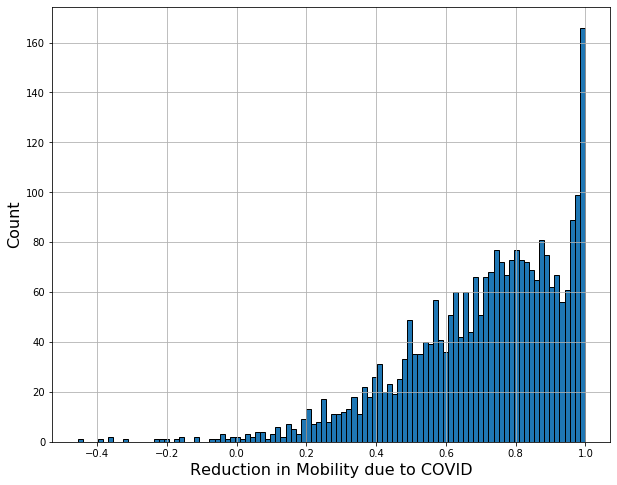

In [26]:
plt.figure(figsize=(10,8))
plt.rcParams["patch.force_edgecolor"] = True

df_mob_spend_red['Pct_Red_rolling_mean_mob'].hist(bins = 100)
plt.xlabel('Reduction in Mobility due to COVID', fontsize=16)
plt.ylabel('Count', fontsize = 16)
#df_mob_spend_red['loc'] = df_mob_spend_red['fips'].apply(lambda x: get_county_state(county_dict,x))

In [27]:
df_model = get_model_df(df_mob_spend_red,df_county_demo)

In [28]:
df_model

,fips,rolling_mean_mob,Min_rolling_mean_mob,min_date_rolling_mean_mob,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob,mean_covid_case_rate,mean_covid_death_rate,YEAR,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_10.0 to 14.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,AKGVE001
0,01001,10.587000,4.551286,2020-04-10,26,0.021927,0.570106,0.908680,0.040960,2014-2018,...,483.0,475.0,725.0,339.0,393.0,194.0,336.0,1509.0,718.0,0.4602
1,01003,10.735571,4.432000,2020-04-12,28,0.020970,0.587167,0.818000,0.016593,2014-2018,...,1601.0,2390.0,2221.0,2183.0,1775.0,1516.0,1336.0,3961.0,2961.0,0.4609
2,01005,9.663964,4.576286,2020-04-17,33,0.015953,0.526459,1.393094,0.000000,2014-2018,...,199.0,379.0,411.0,323.0,221.0,110.0,284.0,764.0,649.0,0.4731
3,01007,13.149214,8.262571,2020-04-12,28,0.013273,0.371630,1.559630,0.000000,2014-2018,...,181.0,84.0,101.0,170.0,163.0,67.0,53.0,347.0,340.0,0.4294
4,01009,17.604321,9.241143,2020-04-12,28,0.016967,0.475064,0.688148,0.000000,2014-2018,...,425.0,321.0,539.0,484.0,321.0,271.0,244.0,619.0,977.0,0.4331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2654,56033,3.953000,1.506571,2020-04-15,31,0.019964,0.618879,1.483500,0.000000,2014-2018,...,340.0,692.0,521.0,415.0,431.0,176.0,271.0,716.0,394.0,0.4383
2655,56035,2.873893,0.464857,2020-04-06,22,0.038102,0.838248,0.483333,0.000000,2014-2018,...,146.0,82.0,45.0,54.0,23.0,12.0,5.0,76.0,142.0,0.3580
2656,56037,8.361857,2.241571,2020-04-16,32,0.022873,0.731929,0.859161,0.000000,2014-2018,...,506.0,648.0,431.0,273.0,366.0,146.0,214.0,709.0,284.0,0.4127
2657,56039,5.573429,0.656000,2020-04-06,22,0.040104,0.882299,5.860381,0.000000,2014-2018,...,369.0,197.0,840.0,563.0,274.0,188.0,424.0,395.0,212.0,0.4879
